In [88]:
import fredapi
from fredapi import Fred
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import coint
from statsmodels.tsa.vector_ar.vecm import *
import statsmodels.api as sm
import numpy as np
import pandas as pd
import yfinance as yf
from scipy.stats import norm
from scipy import stats
from scipy.stats import kurtosis
from scipy.stats import skew
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [13]:
%%R
install.packages(c("portes", "vars", "tseries", "fracdiff", "tsoutliers"))
library("portes")
library("vars")
library("tseries")
library("fracdiff")
library("tsoutliers")

R[write to console]: Installing packages into 'C:/Users/micuk/Documents/R/win-library/4.1'
(as 'lib' is unspecified)



--- Please select a CRAN mirror for use in this session ---


R[write to console]: trying URL 'https://cloud.r-project.org/bin/windows/contrib/4.1/portes_5.0.zip'

R[write to console]: Content type 'application/zip'
R[write to console]:  length 557584 bytes (544 KB)

R[write to console]: downloaded 544 KB


R[write to console]: trying URL 'https://cloud.r-project.org/bin/windows/contrib/4.1/vars_1.5-6.zip'

R[write to console]: Content type 'application/zip'
R[write to console]:  length 426279 bytes (416 KB)

R[write to console]: downloaded 416 KB


R[write to console]: trying URL 'https://cloud.r-project.org/bin/windows/contrib/4.1/tseries_0.10-49.zip'

R[write to console]: Content type 'application/zip'
R[write to console]:  length 409886 bytes (400 KB)

R[write to console]: downloaded 400 KB


R[write to console]: trying URL 'https://cloud.r-project.org/bin/windows/contrib/4.1/fracdiff_1.5-1.zip'

R[write to console]: Content type 'application/zip'
R[write to console]:  length 135906 bytes (132 KB)

R[write to console]: downloaded 132 KB


R[w

package 'portes' successfully unpacked and MD5 sums checked
package 'vars' successfully unpacked and MD5 sums checked
package 'tseries' successfully unpacked and MD5 sums checked
package 'fracdiff' successfully unpacked and MD5 sums checked
package 'tsoutliers' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\micuk\AppData\Local\Temp\RtmpWCSt9P\downloaded_packages


R[write to console]: Loading required package: parallel

R[write to console]: Loading required package: forecast

R[write to console]: Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 

R[write to console]: Loading required package: MASS

R[write to console]: Loading required package: strucchange

R[write to console]: Loading required package: zoo

R[write to console]: 
Attaching package: 'zoo'


R[write to console]: The following objects are masked from 'package:base':

    as.Date, as.Date.numeric


R[write to console]: Loading required package: sandwich

R[write to console]: Loading required package: urca

R[write to console]: Loading required package: lmtest

R[write to console]: 
    'tseries' version: 0.10-49

    'tseries' is a package for time series analysis and computational
    finance.

    See 'library(help="tseries")' for details.




Let's start with downloading some data. I've chosen NASDAQ prices for between 1980 and 1990:

<AxesSubplot:xlabel='Date'>

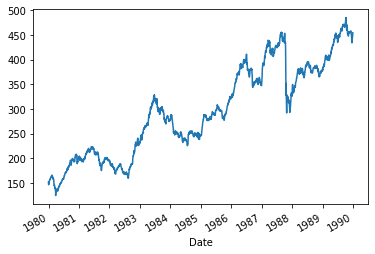

In [10]:
data = yf.Ticker("^IXIC").history(start="1980-01-01", end="1990-01-01")["Close"]
data.plot()

Right in the beginning, let us check if the series has got long or medium memory:

In [122]:
%%R -i data
fracdiff::fdGPH(data)

$d
[1] 1.044882

$sd.as
[1] 0.1030489

$sd.reg
[1] 0.06430204



The parameter d is bigger than 0.5 - it contains no long nor medium memory, so we can proceed. Now it is necessary to check, if the downloaded series is stationary. I will do that by carrying out the ADF and KPSS tests. The series will be considered as stationary only if both of the tests prove stationary:

In [17]:
%%R -i data
print(adf.test(as.ts(data)))
print(kpss.test(as.ts(data)))


	Augmented Dickey-Fuller Test

data:  as.ts(data)
Dickey-Fuller = -2.8605, Lag order = 13, p-value = 0.214
alternative hypothesis: stationary


	KPSS Test for Level Stationarity

data:  as.ts(data)
KPSS Level = 24.777, Truncation lag parameter = 8, p-value = 0.01



In [20]:
returns = data.diff(1)[1:]
log_returns = np.log(data).diff(1)[1:]

In [21]:
%%R -i returns
print(adf.test(as.ts(returns)))
print(kpss.test(as.ts(returns)))


	Augmented Dickey-Fuller Test

data:  as.ts(returns)
Dickey-Fuller = -12.183, Lag order = 13, p-value = 0.01
alternative hypothesis: stationary


	KPSS Test for Level Stationarity

data:  as.ts(returns)
KPSS Level = 0.036385, Truncation lag parameter = 8, p-value = 0.1



In [22]:
%%R -i log_returns
print(adf.test(as.ts(log_returns)))
print(kpss.test(as.ts(log_returns)))


	Augmented Dickey-Fuller Test

data:  as.ts(log_returns)
Dickey-Fuller = -11.698, Lag order = 13, p-value = 0.01
alternative hypothesis: stationary


	KPSS Test for Level Stationarity

data:  as.ts(log_returns)
KPSS Level = 0.056887, Truncation lag parameter = 8, p-value = 0.1



As shown above, both of the returns are stationary. In such case, let's start with analysing the distributions:

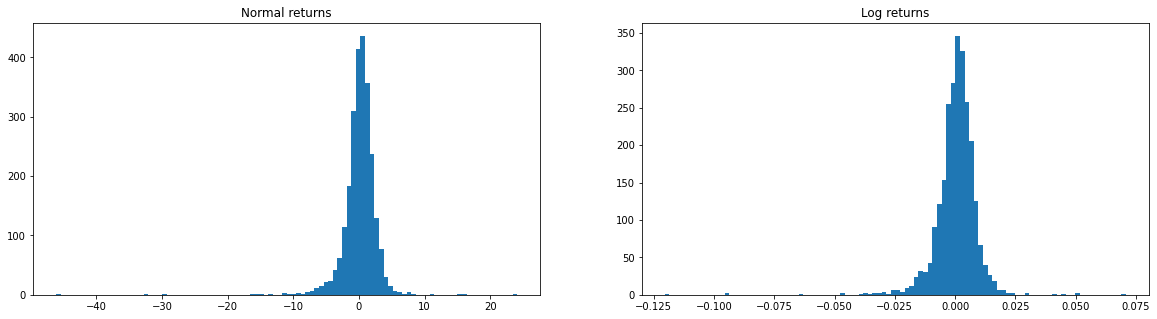

In [66]:
fig, ax = plt.subplots(1,2, figsize=(20,5))

ax[0].hist(returns, bins=100)
ax[0].title.set_text("Normal returns")

ax[1].hist(log_returns, bins=100)
ax[1].title.set_text("Log returns")

plt.show()

The distributions do not seem to have more than one peak, and they appear to have heavy tails. The next step will be checking qqplots:

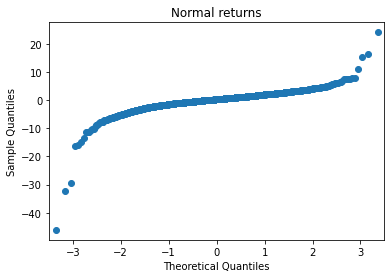

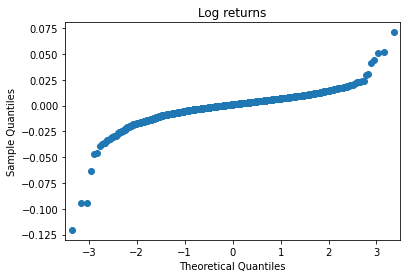

In [74]:
sm.qqplot(returns)
plt.title("Normal returns")
plt.show()
sm.qqplot(log_returns)
plt.title("Log returns")
plt.show()

 As expected, the qqplots also show heavy tails, with a little bit of skewness - the series tends to have more extreme negative returns than positive. Let us calculate the kurtosis and skewness then:

In [89]:
res = pd.DataFrame({"Kurtosis": [kurtosis(returns), kurtosis(log_returns)], "Skewness": [skew(returns), skew(log_returns)]}, index=["returns", "log returns"])
res

,Kurtosis,Skewness
returns,61.241339,-3.783896
log returns,31.941003,-2.417267


Log returns clearly show skewness and kurtosis closer to normal distribution. In such case I will check their normality using Jarque-Bera test:

In [56]:
%%R
print("Normal returns: ")
print(jarque.bera.test(returns))
print("-------------------------------")
print("Log returns: ")
print(jarque.bera.test(log_returns))

[1] "Normal returns: "

	Jarque Bera Test

data:  returns
X-squared = 401085, df = 2, p-value < 2.2e-16

[1] "-------------------------------"
[1] "Log returns: "

	Jarque Bera Test

data:  log_returns
X-squared = 109926, df = 2, p-value < 2.2e-16



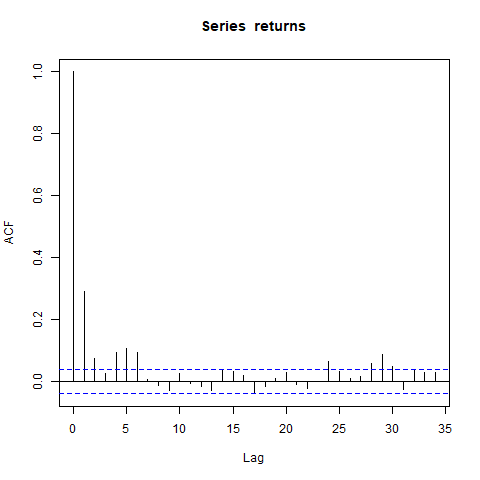

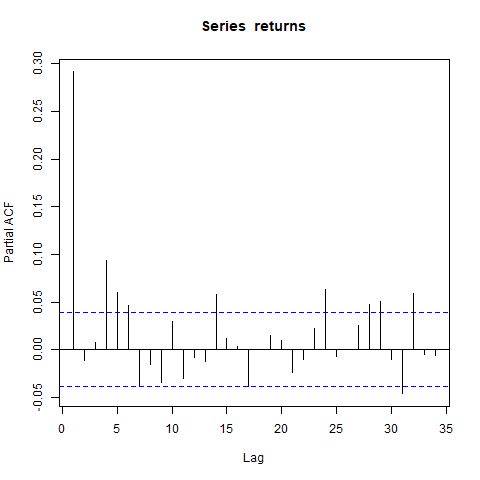

In [92]:
%%R

acf(returns)
pacf(returns)

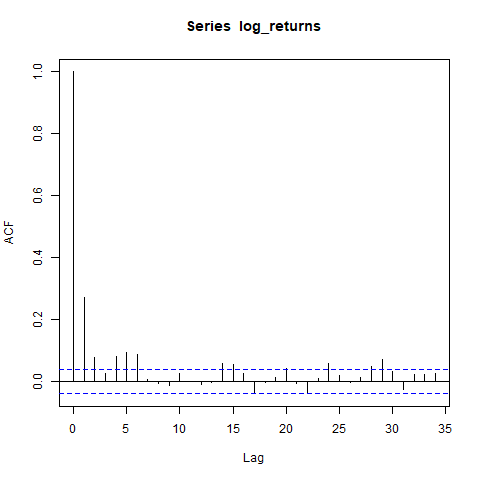

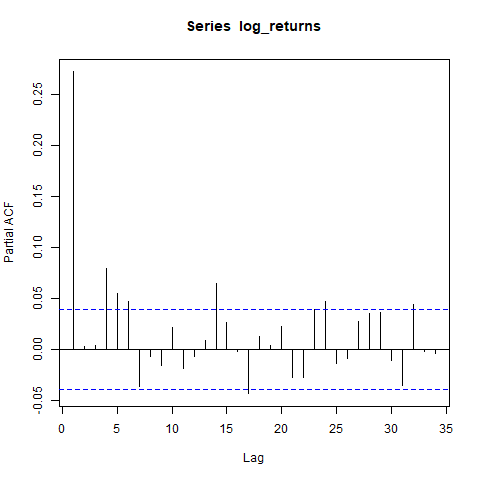

In [96]:
%%R

acf(log_returns)
pacf(log_returns)

It's worth noting that the plots above suggest seasonality

In [99]:
%%R
print(LjungBox(returns))
print(LjungBox(log_returns))

 lags statistic df p-value
    5  282.8175  5       0
   10  309.6167 10       0
   15  318.8461 15       0
   20  326.4090 20       0
   25  342.0877 25       0
   30  378.7536 30       0
 lags statistic df p-value
    5  242.3976  5       0
   10  263.9232 10       0
   15  281.1797 15       0
   20  290.7828 20       0
   25  304.6667 25       0
   30  326.4139 30       0


Both types of returns show statistically significant autocorrelations and partial autocorrelations. Since we've confirmed linear relationships, let's test for quadriatic autocorrelation (ARCH effect), and let's visualise it:

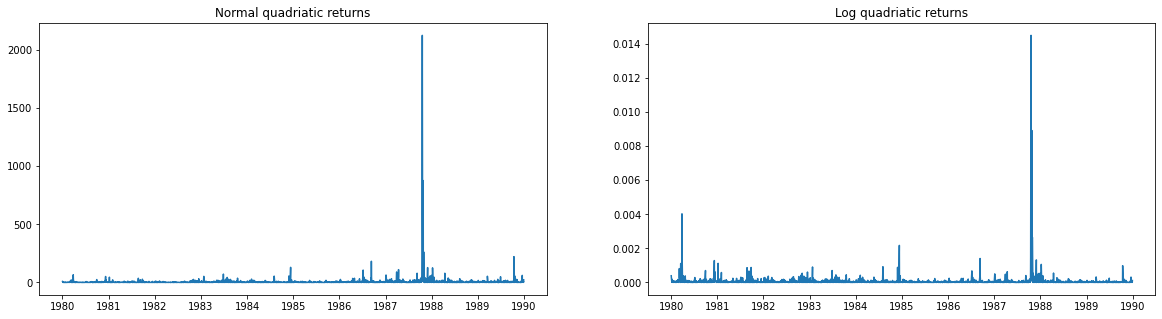

In [108]:
q_returns = returns ** 2
q_log_returns = log_returns ** 2

fig, ax = plt.subplots(1,2, figsize=(20,5))

ax[0].plot(q_returns)
ax[0].title.set_text("Normal quadriatic returns")

ax[1].plot(q_log_returns)
ax[1].title.set_text("Log quadriatic returns")

plt.show()

The plots suggest that there is some conditional heteroskedasticity. Let's confirm it with additional tests:

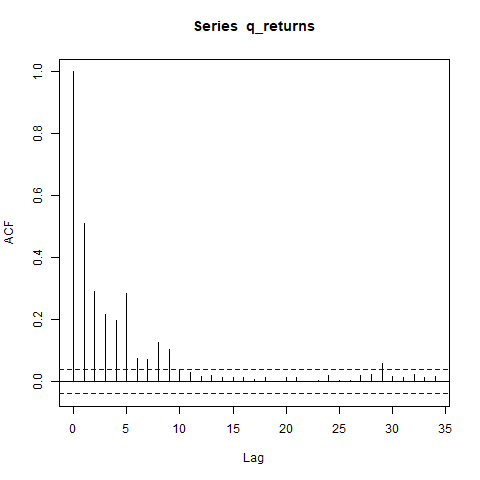

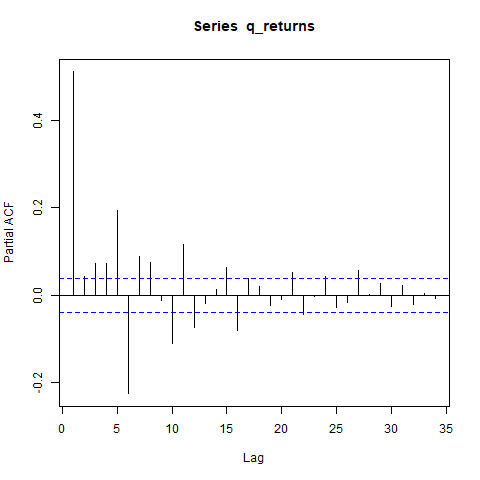

In [110]:
%%R -i q_returns

acf(q_returns)
pacf(q_returns)

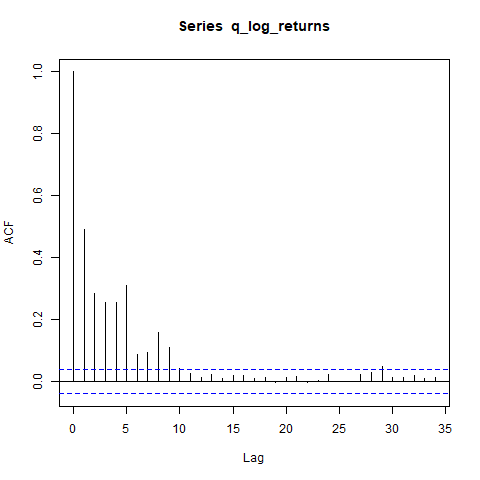

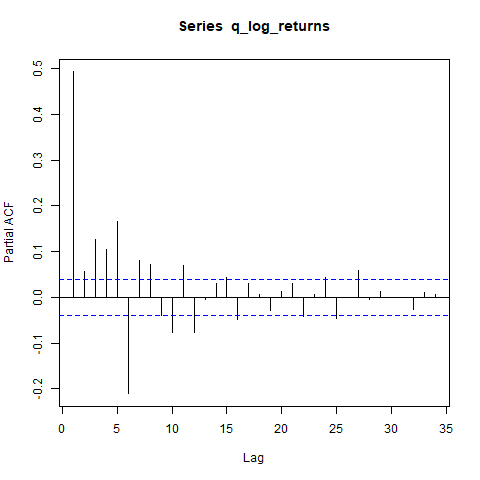

In [112]:
%%R -i q_log_returns

acf(q_log_returns)
pacf(q_log_returns)

The ACF and PACF suggest there indeed might be some ARCH or GARCH effect. Let's now confirm it with Ljung-Box test with the preassumption of the mean equal to 0:

In [124]:
%%R

print(LjungBox(q_returns))
print(LjungBox(q_log_returns))

 lags statistic df p-value
    5  1295.343  5       0
   10  1394.289 10       0
   15  1399.108 15       0
   20  1400.650 20       0
   25  1402.139 25       0
   30  1414.533 30       0
 lags statistic df p-value
    5  1395.303  5       0
   10  1536.878 10       0
   15  1541.637 15       0
   20  1543.515 20       0
   25  1545.574 25       0
   30  1554.989 30       0


Ljung-Box test has confrimed, that there is a quadriatic relationship in the series. The Engle's ARCH test will be covered in another section, dedicated to volatility. Since it has been confirmed, that log returns present better statistical features, normal returns will not be taken into account in any further analysis.